<a href="https://colab.research.google.com/github/erdult/Fine-Tune-LLM/blob/main/online_training_pytorch_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import pandas as pd
# import numpy as np
# import torch
# import yfinance as yf
# tickers = ['MSFT', 'META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']  # FAANG + MSFT

# # Download data for all tickers
# data = yf.download(tickers, start='2020-01-01', end=pd.to_datetime('today'))
# data



In [2]:
# all_data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
# all_data
# # msft_data = all_data[all_data['Ticker'] == 'MSFT']
# # msft_dkata
# #all_data['MSFT']
# close_prices = data['Adj Close']
# close_prices.columns = tickers

In [3]:
# close_prices['MSFT']

In [4]:
import pandas as pd
import numpy as np
import torch

import yfinance as yf

# Check PyTorch version and CUDA availability
print(torch.__version__)
print(torch.cuda.is_available())

# Pull MSFT prices using yfinance
msft_data = yf.download('MSFT', start='2020-01-01', end='2024-12-01')
msft_data.to_parquet('msft_data.parquet')
#msft_data = pd.read_csv('msft_data.csv', index_col='Date', parse_dates=['Date'])
# Prepare the data for time series forecasting
msft_data['target'] = msft_data['Close'].shift(-1)  # Shift the close price to create a target for the next time step
msft_data.dropna(inplace=True)  # Drop the last row with NaN target

2.5.1+cu121
False


[*********************100%***********************]  1 of 1 completed


In [5]:
msft_data.head()

Price,Adj Close,Close,High,Low,Open,Volume,target
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,
Date,,,,,,,
2020-01-02,153.938202,160.619995,160.729996,158.330002,158.779999,22622100,158.619995
2020-01-03,152.021408,158.619995,159.949997,158.059998,158.320007,21116200,159.029999
2020-01-06,152.414352,159.029999,159.100006,156.509995,157.080002,20813700,157.580002
2020-01-07,151.024689,157.580002,159.669998,157.320007,159.320007,21634100,160.089996
2020-01-08,153.430252,160.089996,160.800003,157.949997,158.929993,27746500,162.089996


In [6]:
msft_data.reset_index()

Price,Date,Adj Close,Close,High,Low,Open,Volume,target
Ticker,,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,
0,2020-01-02,153.938202,160.619995,160.729996,158.330002,158.779999,22622100,158.619995
1,2020-01-03,152.021408,158.619995,159.949997,158.059998,158.320007,21116200,159.029999
2,2020-01-06,152.414352,159.029999,159.100006,156.509995,157.080002,20813700,157.580002
3,2020-01-07,151.024689,157.580002,159.669998,157.320007,159.320007,21634100,160.089996
4,2020-01-08,153.430252,160.089996,160.800003,157.949997,158.929993,27746500,162.089996
...,...,...,...,...,...,...,...,...
1231,2024-11-21,412.869995,412.869995,419.779999,410.290009,419.500000,20780200,417.000000
1232,2024-11-22,417.000000,417.000000,417.399994,411.059998,411.369995,24814600,418.790009
1233,2024-11-25,418.790009,418.790009,421.079987,414.850006,418.380005,27691100,427.989990


In [7]:
msft_data.reset_index(inplace=True)
msft_data.columns = msft_data.columns.map(lambda x: x[0] if isinstance(x, tuple) else x)

msft_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume,target
0,2020-01-02,153.938202,160.619995,160.729996,158.330002,158.779999,22622100,158.619995
1,2020-01-03,152.021408,158.619995,159.949997,158.059998,158.320007,21116200,159.029999
2,2020-01-06,152.414352,159.029999,159.100006,156.509995,157.080002,20813700,157.580002
3,2020-01-07,151.024689,157.580002,159.669998,157.320007,159.320007,21634100,160.089996
4,2020-01-08,153.430252,160.089996,160.800003,157.949997,158.929993,27746500,162.089996


Correlation between target and Close: 1.00


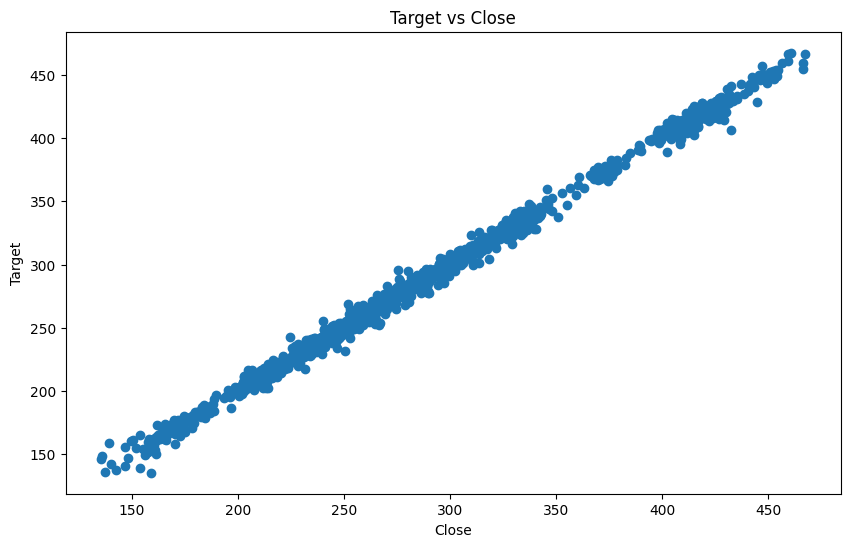

Autocorrelation between target and Close: 1.00


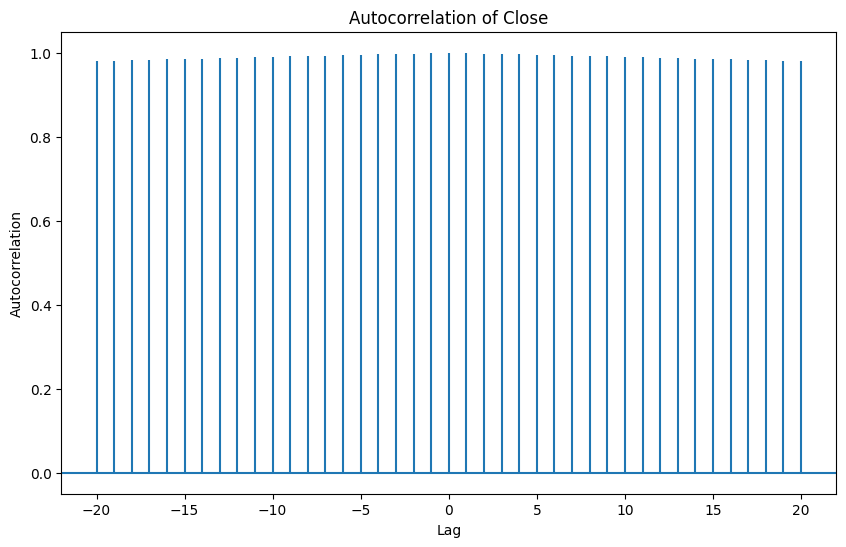

Returns Correlation between target and Close: -0.18


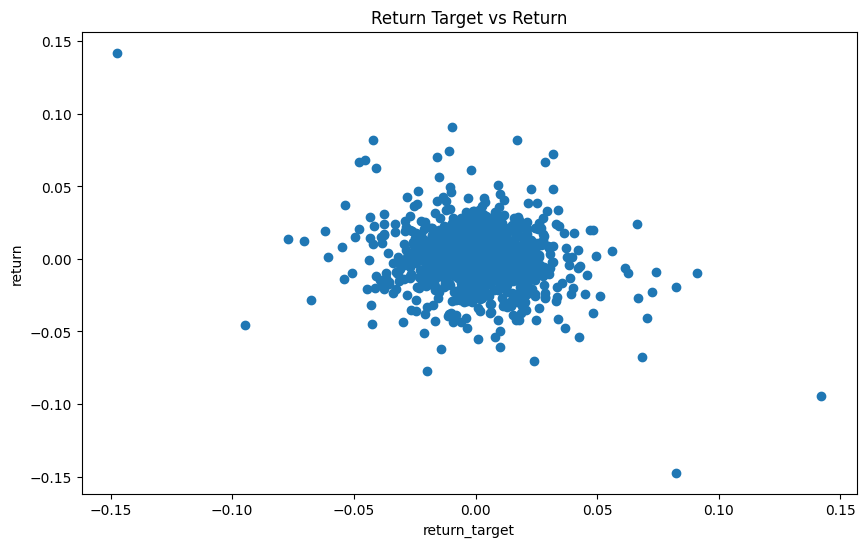

Autocorrelation between target and Close: -0.18


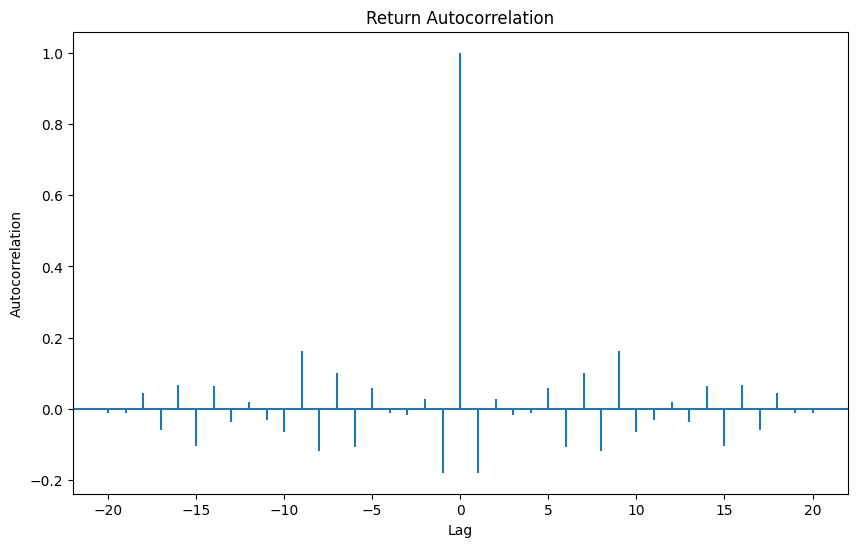

In [8]:
# some EDA
# Correlation between target and Close
# Plot of target vs Close
# Autocorrelation between target and Close
# Correlation between target and Close
msft_data['return'] = msft_data['Close'].pct_change()
msft_data['return_target'] = msft_data['return'].shift(-1)
# print(msft_data.head())

correlation = msft_data['target'].corr(msft_data['Close'])
print(f"Correlation between target and Close: {correlation:.2f}")

# Plot of target vs Close
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(msft_data['Close'], msft_data['target'])
plt.xlabel('Close')
plt.ylabel('Target')
plt.title('Target vs Close')
plt.show()




# Calculate autocorrelation
autocorrelation = pd.Series(msft_data['Close']).autocorr(lag=1)
print(f"Autocorrelation between target and Close: {autocorrelation:.2f}")

# Plot autocorrelation
plt.figure(figsize=(10,6))
plt.acorr(msft_data['Close'], maxlags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Close')
plt.show()



## Returns
correlation = msft_data['return_target'].corr(msft_data['return'])
print(f"Returns Correlation between target and Close: {correlation:.2f}")

# Plot of target vs Close

plt.figure(figsize=(10,6))
plt.scatter(msft_data['return_target'], msft_data['return'])
plt.xlabel('return_target')
plt.ylabel('return')
plt.title('Return Target vs Return')
plt.show()

# Calculate autocorrelation
autocorrelation = pd.Series(msft_data['return']).autocorr(lag=1)
print(f"Autocorrelation between target and Close: {autocorrelation:.2f}")

# Plot autocorrelation
plt.figure(figsize=(10,6))
plt.acorr(msft_data['return'].dropna(), maxlags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Return Autocorrelation')
plt.show()





In [9]:
# last day return gives a little info about the future return

In [10]:
msft_data

,Date,Adj Close,Close,High,Low,Open,Volume,target,return,return_target
0,2020-01-02,153.938202,160.619995,160.729996,158.330002,158.779999,22622100,158.619995,NaN,-0.012452
1,2020-01-03,152.021408,158.619995,159.949997,158.059998,158.320007,21116200,159.029999,-0.012452,0.002585
2,2020-01-06,152.414352,159.029999,159.100006,156.509995,157.080002,20813700,157.580002,0.002585,-0.009118
3,2020-01-07,151.024689,157.580002,159.669998,157.320007,159.320007,21634100,160.089996,-0.009118,0.015928
4,2020-01-08,153.430252,160.089996,160.800003,157.949997,158.929993,27746500,162.089996,0.015928,0.012493
...,...,...,...,...,...,...,...,...,...,...
1231,2024-11-21,412.869995,412.869995,419.779999,410.290009,419.500000,20780200,417.000000,-0.006306,0.010003
1232,2024-11-22,417.000000,417.000000,417.399994,411.059998,411.369995,24814600,418.790009,0.010003,0.004293
1233,2024-11-25,418.790009,418.790009,421.079987,414.850006,418.380005,27691100,427.989990,0.004293,0.021968
1234,2024-11-26,427.989990,427.989990,429.040009,418.850006,419.589996,23458900,422.989990,0.021968,-0.011683


In [11]:
msft_data[['Close','target','return']]

,Close,target,return
0,160.619995,158.619995,NaN
1,158.619995,159.029999,-0.012452
2,159.029999,157.580002,0.002585
3,157.580002,160.089996,-0.009118
4,160.089996,162.089996,0.015928
...,...,...,...
1231,412.869995,417.000000,-0.006306
1232,417.000000,418.790009,0.010003
1233,418.790009,427.989990,0.004293
1234,427.989990,422.989990,0.021968


In [12]:
msft_data[['Close', 'return']].values

array([[ 1.60619995e+02,             nan],
       [ 1.58619995e+02, -1.24517498e-02],
       [ 1.59029999e+02,  2.58481701e-03],
       ...,
       [ 4.18790009e+02,  4.29258644e-03],
       [ 4.27989990e+02,  2.19680066e-02],
       [ 4.22989990e+02, -1.16825162e-02]])

In [13]:
### PYTORCH WAY
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        # so input should be created in batch_size x sequence_length x input_dim
        # hidden_dim is the internal dimension of network
        # next layer is the linear output from hidden_dimension
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model, optimizer, and loss function
model = RNN(input_dim=1, hidden_dim=32, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Set the batch size
batch_size = 32
sequence_length = 16


def create_sequences(data_x, data_y, seq_length):
       X = []
       y = []
       for i in range(len(data_x) - seq_length):
           X.append(data_x[i:(i + seq_length)])
           y.append(data_y[i + seq_length])  # Target is the next value in the sequence
       return np.array(X), np.array(y)

seq_length = 16  # Choose an appropriate sequence length

# .values create an array where each element is [Close, return] array
msft_data_no_na = msft_data[['return', 'return_target', 'Date']].dropna()
from sklearn.preprocessing import StandardScaler





# 2. Create a StandardScaler object
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# 3. Fit the scaler and transform the data
scaled_data_x = scaler_x.fit_transform(msft_data_no_na[['return']].values)
scaled_data_y = scaler_y.fit_transform(msft_data_no_na[['return_target']].values)

print(len(scaled_data_x))
print(len(scaled_data_y))

X, y = create_sequences(data_x= scaled_data_x,
                        data_y = scaled_data_y , seq_length=seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)[:, 0].unsqueeze(1) # Keep only 'target' and reshape

from torch.utils.data import DataLoader , TensorDataset
dataset = TensorDataset(X, y)
dl = DataLoader(dataset, batch_size=batch_size)


num_epochs = 10
for epoch in range(num_epochs):
  # Iterate over the data in batches

  # Initialize lists to store predictions and MSE, only last epoch will be kept
  predictions_scaled = []
  mse_values = []
  for i, (batch_x, batch_y) in enumerate(dl):
      # i is the batch index, (batch_x, batch_y) are the data
      # batch_x and batch_y are already tensors
      # if i == 1:
        # print(batch_x)
        # print(batch_x.size())

            # Zero the gradients
      optimizer.zero_grad()

      # Forward pass
      y_pred = model(batch_x)
      loss = loss_fn(y_pred, batch_y)

      # Store the predictions
      predictions_scaled.append(y_pred)

      # Compute the MSE
      mse = loss.item()
      mse_values.append(mse)



      # Backward pass
      loss.backward()

      # Update the model parameters
      optimizer.step()

      # Print the MSE at each step
      # print(f"Step {i+1}, MSE: {mse:.4f}") # Use i+1 for batch index

  epoch_loss = np.mean(mse_values)
  print(f"Epoch {epoch + 1}, Average MSE: {epoch_loss:.4f}")


# Inverse transform predictions
# predictions = scaler_y.inverse_transform(predictions_scaled.cpu().detach().numpy())

# Print the final MSE
# print(f"Final MSE: {np.mean(mse_values):.4f}")

1234
1234
Epoch 1, Average MSE: 1.0109
Epoch 2, Average MSE: 1.0050
Epoch 3, Average MSE: 1.0023
Epoch 4, Average MSE: 0.9989
Epoch 5, Average MSE: 0.9950
Epoch 6, Average MSE: 0.9921
Epoch 7, Average MSE: 0.9897
Epoch 8, Average MSE: 0.9869
Epoch 9, Average MSE: 0.9844
Epoch 10, Average MSE: 0.9835


39
32
2
tensor([[ 0.0680],
        [ 0.0981],
        [-0.0990],
        [-0.0382],
        [ 0.0257],
        [ 0.0223],
        [-0.0077],
        [-0.2507],
        [ 0.2104],
        [-0.0710],
        [-0.0336],
        [-0.1081],
        [-0.0350],
        [ 0.1735],
        [-0.2098],
        [ 0.1466],
        [-0.1647],
        [ 0.1855],
        [-0.1280],
        [-0.0164],
        [-0.0445],
        [ 0.0215],
        [ 0.0074],
        [ 0.1457],
        [ 0.0077],
        [-0.3151],
        [ 0.3739],
        [-0.0818],
        [-0.1696],
        [ 0.1349],
        [-0.1555],
        [ 0.1406]], grad_fn=<AddmmBackward0>)


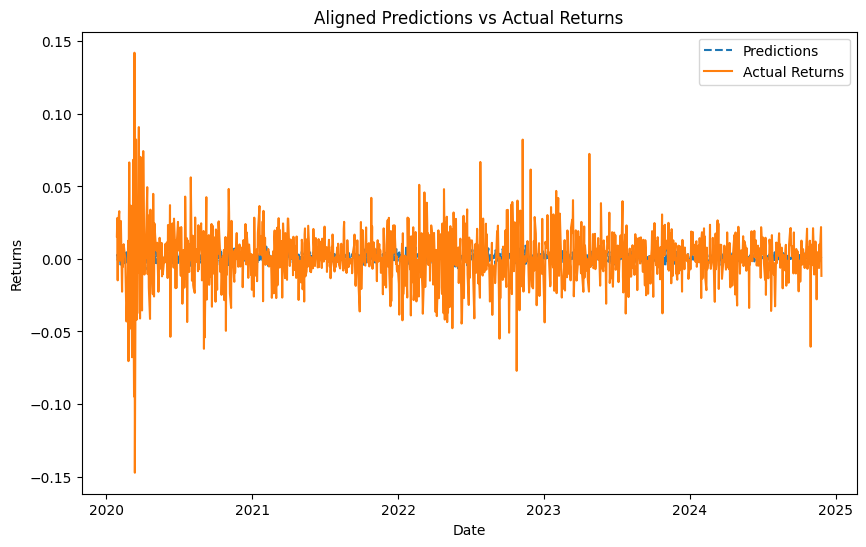

In [14]:
# convert predictions array so that you can plot it
print(len(predictions_scaled))
print(len(predictions_scaled[0]))
print(len(predictions_scaled[38]))
# print(predictions[37])
# print(38*32+18)
# print( sum([len(x) for x in predictions]) )
print(predictions_scaled[0])

predictions_scaled = torch.cat(predictions_scaled, dim=0)

# each prediction has size of 32 which is same as batch size, in each batch there is a sequence of length 16 in it and input size of 2
# there are 39 iterations/batches
# each batch creates 32 output
# last batch is length 18



# Inverse transform predictions
predictions = scaler_y.inverse_transform(predictions_scaled.cpu().detach().numpy())




#Get the range of target values used for prediction
prediction_start_index = seq_length
prediction_end_index = len(msft_data_no_na) - 1 # End index adjusted to account for sequence length and shift

# Slice target values to match the prediction range
target_values = msft_data_no_na['return_target'][prediction_start_index:prediction_end_index + 1].values # +1 to include the last index

# X values for plotting (use date or index for a more informative x-axis)
x_values = msft_data_no_na['Date'][prediction_start_index:prediction_end_index + 1] # Using the 'Date' column

# Assuming predictions is already inverse transformed
predictions_aligned = predictions.flatten() # Flatten predictions to a 1D array

# Plot the predictions and target values (aligned)
plt.figure(figsize=(10, 6))
plt.plot(x_values, predictions_aligned, label='Predictions', linestyle='--')  # Use x_values for aligned x-axis
plt.plot(x_values, target_values, label='Actual Returns')  # Use the same x_values
plt.legend()
plt.xlabel('Date') # Or other relevant label for your x_values
plt.ylabel('Returns')
plt.title('Aligned Predictions vs Actual Returns')
plt.show()#

In [15]:
from sklearn.model_selection import train_test_split

# Create a class to store model-related objects
class TimeSeriesModel:
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        # drop out rate might need to be addded to RNN class
        self.model = RNN(input_dim, hidden_dim, output_dim)
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=0.001)
        self.loss_fn = nn.MSELoss()

    def create_sequences(self, data_x, data_y, seq_length):
        # ... (your create_sequences function) ...
        X = []
        y = []
        for i in range(len(data_x) - seq_length):
          X.append(data_x[i:(i + seq_length)])
          y.append(data_y[i + seq_length])  # Target is the next value in the sequence
        return np.array(X), np.array(y)

    def fit(self, train_data, test_data, val_data, seq_length, batch_size=32, num_epochs=10):
        # # 1. Split data into train, validation, and test sets
        # train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
        # train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

        # 2. Scale data
        self.scaler_x.fit(train_data[['return']].values)
        self.scaler_y.fit(train_data[['return_target']].values)

        scaled_data_x_train = self.scaler_x.transform(train_data[['return']].values)
        scaled_data_y_train = self.scaler_y.transform(train_data[['return_target']].values)

        # 3. Create DataLoaders
        X_train, y_train = self.create_sequences(scaled_data_x_train, scaled_data_y_train, seq_length)
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)[:, 0].unsqueeze(1)
        train_dataset = TensorDataset(X_train, y_train)
        train_dl = DataLoader(train_dataset, batch_size=batch_size)

        # ... (similarly create val_dl and test_dl) ...

        # 4. Training loop (with early stopping if needed)
        # ... (your training loop with epochs, loss calculation, early stopping, etc.) ...
        num_epochs = 10
        for epoch in range(num_epochs):
          # Iterate over the data in batches

          # Initialize lists to store predictions and MSE, only last epoch will be kept
          predictions_scaled = []
          mse_values = []
          for i, (batch_x, batch_y) in enumerate(dl):
              # i is the batch index, (batch_x, batch_y) are the data
              # batch_x and batch_y are already tensors
              # if i == 1:
                # print(batch_x)
                # print(batch_x.size())

              # Zero the gradients
              self.optimizer.zero_grad()



              # Forward pass
              y_pred = self.model(batch_x)
              loss = self.loss_fn(y_pred, batch_y)

              # Store the predictions
              predictions_scaled.append(y_pred)

              # Compute the MSE
              mse = loss.item()
              mse_values.append(mse)



              # Backward pass
              loss.backward()

              # Update the model parameters
              self.optimizer.step()

              # Print the MSE at each step
              # print(f"Step {i+1}, MSE: {mse:.4f}") # Use i+1 for batch index

          epoch_loss = np.mean(mse_values)
          print(f"Epoch {epoch + 1}, Average MSE: {epoch_loss:.4f}")


        # 5. Return the trained model and other objects
        return self  # Return the TimeSeriesModel instance


train_data, test_data = train_test_split(msft_data_no_na, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

fit_model = TimeSeriesModel(input_dim=1, hidden_dim=10, output_dim=1)
fit_model.fit(train_data, test_data, val_data, seq_length, batch_size=32, num_epochs=10)

Epoch 1, Average MSE: 1.0061
Epoch 2, Average MSE: 1.0029
Epoch 3, Average MSE: 1.0019
Epoch 4, Average MSE: 1.0010
Epoch 5, Average MSE: 1.0001
Epoch 6, Average MSE: 0.9992
Epoch 7, Average MSE: 0.9982
Epoch 8, Average MSE: 0.9973
Epoch 9, Average MSE: 0.9963
Epoch 10, Average MSE: 0.9954


In [16]:
# prompt: generate predictions for test_data, and val_data then concatenate themn

def predict(model, data, seq_length, scaler_x, scaler_y):
    scaled_data_x = model.scaler_x.transform(data[['return']].values)
    X, _ = model.create_sequences(scaled_data_x, scaled_data_x, seq_length) # Dummy y for prediction
    X = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        predictions_scaled = model.model(X)
    predictions = model.scaler_y.inverse_transform(predictions_scaled.cpu().detach().numpy())
    return predictions

# Generate predictions for test and validation data
test_predictions = predict(fit_model, test_data, seq_length, fit_model.scaler_x, fit_model.scaler_y)
val_predictions = predict(fit_model, val_data, seq_length, fit_model.scaler_x, fit_model.scaler_y)
train_predictions = predict(fit_model, train_data, seq_length, fit_model.scaler_x, fit_model.scaler_y)
# Concatenate predictions
all_predictions = np.concatenate((val_predictions, test_predictions))

all_predictions = np.concatenate((train_predictions, all_predictions))

In [17]:
print(len(all_predictions))
print(len(msft_data_no_na))

print(len(test_data))
print(len(val_data))
print(len(train_data))

print(len(train_data)+ len(val_data) + len(test_data))

print(len(test_predictions))
print(len(val_predictions))
print(len(train_predictions))

1186
1234
247
198
789
1234
231
182
773


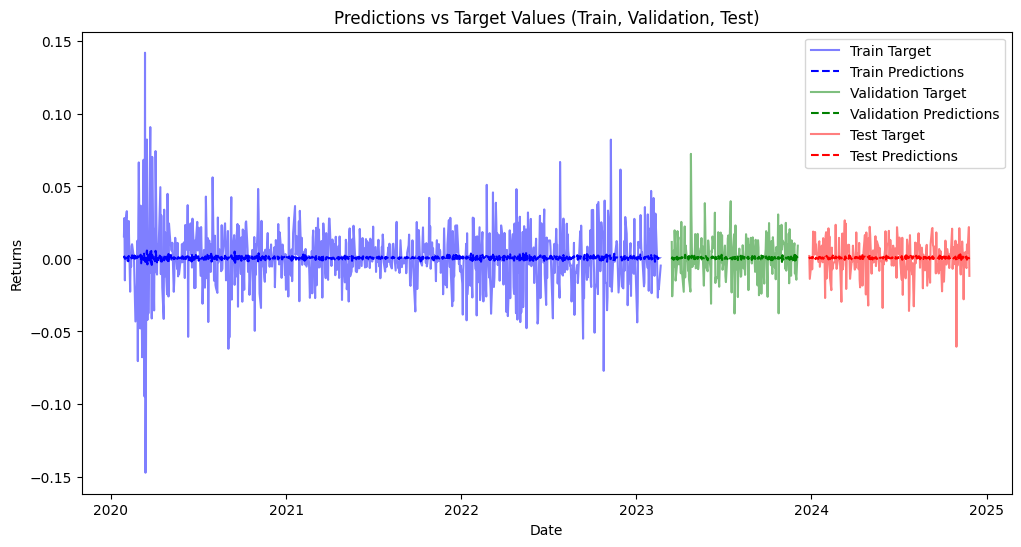

In [18]:
# --- Prepare data for plotting ---
train_target = train_data['return_target'][seq_length:].values  # Slice target values to match predictions
val_target = val_data['return_target'][seq_length:].values
test_target = test_data['return_target'][seq_length:].values

train_dates = train_data['Date'][seq_length:]  # Slice dates to match predictions
val_dates = val_data['Date'][seq_length:]
test_dates = test_data['Date'][seq_length:]

# --- Plotting ---
plt.figure(figsize=(12, 6))

plt.plot(train_dates, train_target, label='Train Target', color='blue', alpha=0.5)  # Train target
plt.plot(train_dates, train_predictions, label='Train Predictions', color='blue', linestyle='--')  # Train predictions

plt.plot(val_dates, val_target, label='Validation Target', color='green', alpha=0.5)  # Validation target
plt.plot(val_dates, val_predictions, label='Validation Predictions', color='green', linestyle='--')  # Validation predictions

plt.plot(test_dates, test_target, label='Test Target', color='red', alpha=0.5)  # Test target
plt.plot(test_dates, test_predictions, label='Test Predictions', color='red', linestyle='--')  # Test predictions

plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Predictions vs Target Values (Train, Validation, Test)')
plt.show()

In [19]:
# If over fit... now redo the problem by creating train, valid, and test data

In [20]:
from sklearn.model_selection import train_test_split

# Assuming msft_data_no_na is your DataFrame with 'Close', 'return', and 'target' columns

# 1. Split into train and test sets (e.g., 80% train, 20% test)
train_data, test_data = train_test_split(msft_data_no_na, test_size=0.2, shuffle=False)

# 2. Split train set into train and validation sets (e.g., 80% train, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

# Now you have:
# - train_data: For training your model
# - val_data: For evaluating performance during training (and hyperparameter tuning)
# - test_data: For final evaluation of your model

# --- Create DataLoaders for each set ---
# (using the same logic as before, but with the respective datasets)

# --- Train DataLoader ---
# ... (your existing code to create scaled_data_x, scaled_data_y, X, y, and dl) ...
# Use train_data instead of msft_data_no_na

# --- Validation DataLoader ---
# ... (Similar to train DataLoader, but use val_data) ...

# --- Test DataLoader ---
# ... (Similar to train DataLoader, but use test_data) ...